In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler

import warnings

warnings.filterwarnings("ignore")


In [2]:
data = pd.read_csv("heart_2022_no_nans.csv")
data.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [3]:
def var_encoding(df):
    #State
    le = LabelEncoder()
    df["State_encoded"] = le.fit_transform(df["State"])
    df = df.drop(columns = ["State"])

    df["Sex"] = df["Sex"].replace({"Female": 0, "Male": 1})

    df["GeneralHealth"] = df["GeneralHealth"].replace({"Poor": 0, "Fair": 1, "Good": 2, "Very good": 3, "Excellent": 4})

    df["LastCheckupTime"] = df["LastCheckupTime"].replace({"Within past year (anytime less than 12 months ago)": 1, 
                                                           "Within past 2 years (1 year but less than 2 years ago)": 2, 
                                                           "Within past 5 years (2 years but less than 5 years ago)": 3, 
                                                           "5 or more years ago": 4})
    df["RemovedTeeth"] = df["RemovedTeeth"].replace({"None of them": 0, "1 to 5": 2, "6 or more, but not all": 3, "All": 4})

    df["HadDiabetes"] = df["HadDiabetes"].replace({"No": 0, "No, pre-diabetes or borderline diabetes": 1, 
                                                   "Yes, but only during pregnancy (female)": 3, "Yes": 4})
    
    df["SmokerStatus"] = df["SmokerStatus"].replace({"Never smoked": 0, "Former smoker": 1, "Current smoker - now smokes some days": 3,
                                                     "Current smoker - now smokes every day": 4})
    
    df["ECigaretteUsage"] = df["ECigaretteUsage"].replace({"Never used e-cigarettes in my entire life": 0, "Not at all (right now)": 1,
                                                           "Use them some days": 0, "Use them every day": 1})

    df["AgeCategory"] = df["AgeCategory"].replace({"Age 18 to 24": 1, "Age 25 to 29": 2, "Age 30 to 34": 3, "Age 35 to 39": 1,
                                                   "Age 40 to 44": 2, "Age 45 to 49": 3, "Age 50 to 54": 4, "Age 55 to 59": 5,
                                                   "Age 60 to 64": 6, "Age 65 to 69": 7, "Age 70 to 74": 8, "Age 75 to 79": 9,
                                                   "Age 80 or older": 10})
    
    df["TetanusLast10Tdap"] = df["TetanusLast10Tdap"].replace({"No, did not receive any tetanus shot in the past 10 years": 0, 
                                                               "Yes, received tetanus shot, but not Tdap": 1,
                                                               "Yes, received tetanus shot but not sure what type": 2,
                                                               "Yes, received Tdap": 3})
    
    df["CovidPos"] = df["CovidPos"].replace({"No": 0, "Tested positive using home test without a health professional": 1, "Yes": 2})

    df = df.replace({'Yes': 1,'No': 0})
    df = pd.get_dummies(df, columns=['RaceEthnicityCategory'], dtype='int')
    return df

data = var_encoding(data)
data.head()

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,...,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,State_encoded,"RaceEthnicityCategory_Black only, Non-Hispanic",RaceEthnicityCategory_Hispanic,"RaceEthnicityCategory_Multiracial, Non-Hispanic","RaceEthnicityCategory_Other race only, Non-Hispanic","RaceEthnicityCategory_White only, Non-Hispanic"
0,0,3,4.0,0.0,1,1,9.0,0,0,0,...,1,3,0,0,0,0,0,0,0,1
1,1,3,0.0,0.0,1,1,6.0,0,0,0,...,1,2,0,0,0,0,0,0,0,1
2,1,3,0.0,0.0,1,0,8.0,3,0,0,...,1,0,0,2,0,0,0,0,0,1
3,0,1,5.0,0.0,1,1,9.0,0,0,0,...,1,0,0,2,0,0,0,0,0,1
4,0,2,3.0,15.0,1,1,5.0,2,0,0,...,1,0,0,0,0,0,0,0,0,1


In [4]:
X = data.drop(columns=["HadHeartAttack"])
y = data["HadHeartAttack"]

undersample = RandomUnderSampler(sampling_strategy='auto')
X_under, y_under = undersample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [5]:
y_pred = rf_model.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      4018
           1       0.81      0.79      0.80      4043

    accuracy                           0.80      8061
   macro avg       0.80      0.80      0.80      8061
weighted avg       0.80      0.80      0.80      8061



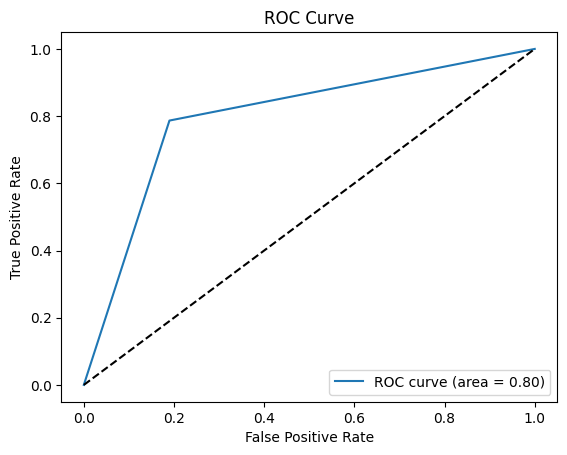

ROC-AUC Score: 0.80


In [6]:
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f'ROC-AUC Score: {roc_auc:.2f}')

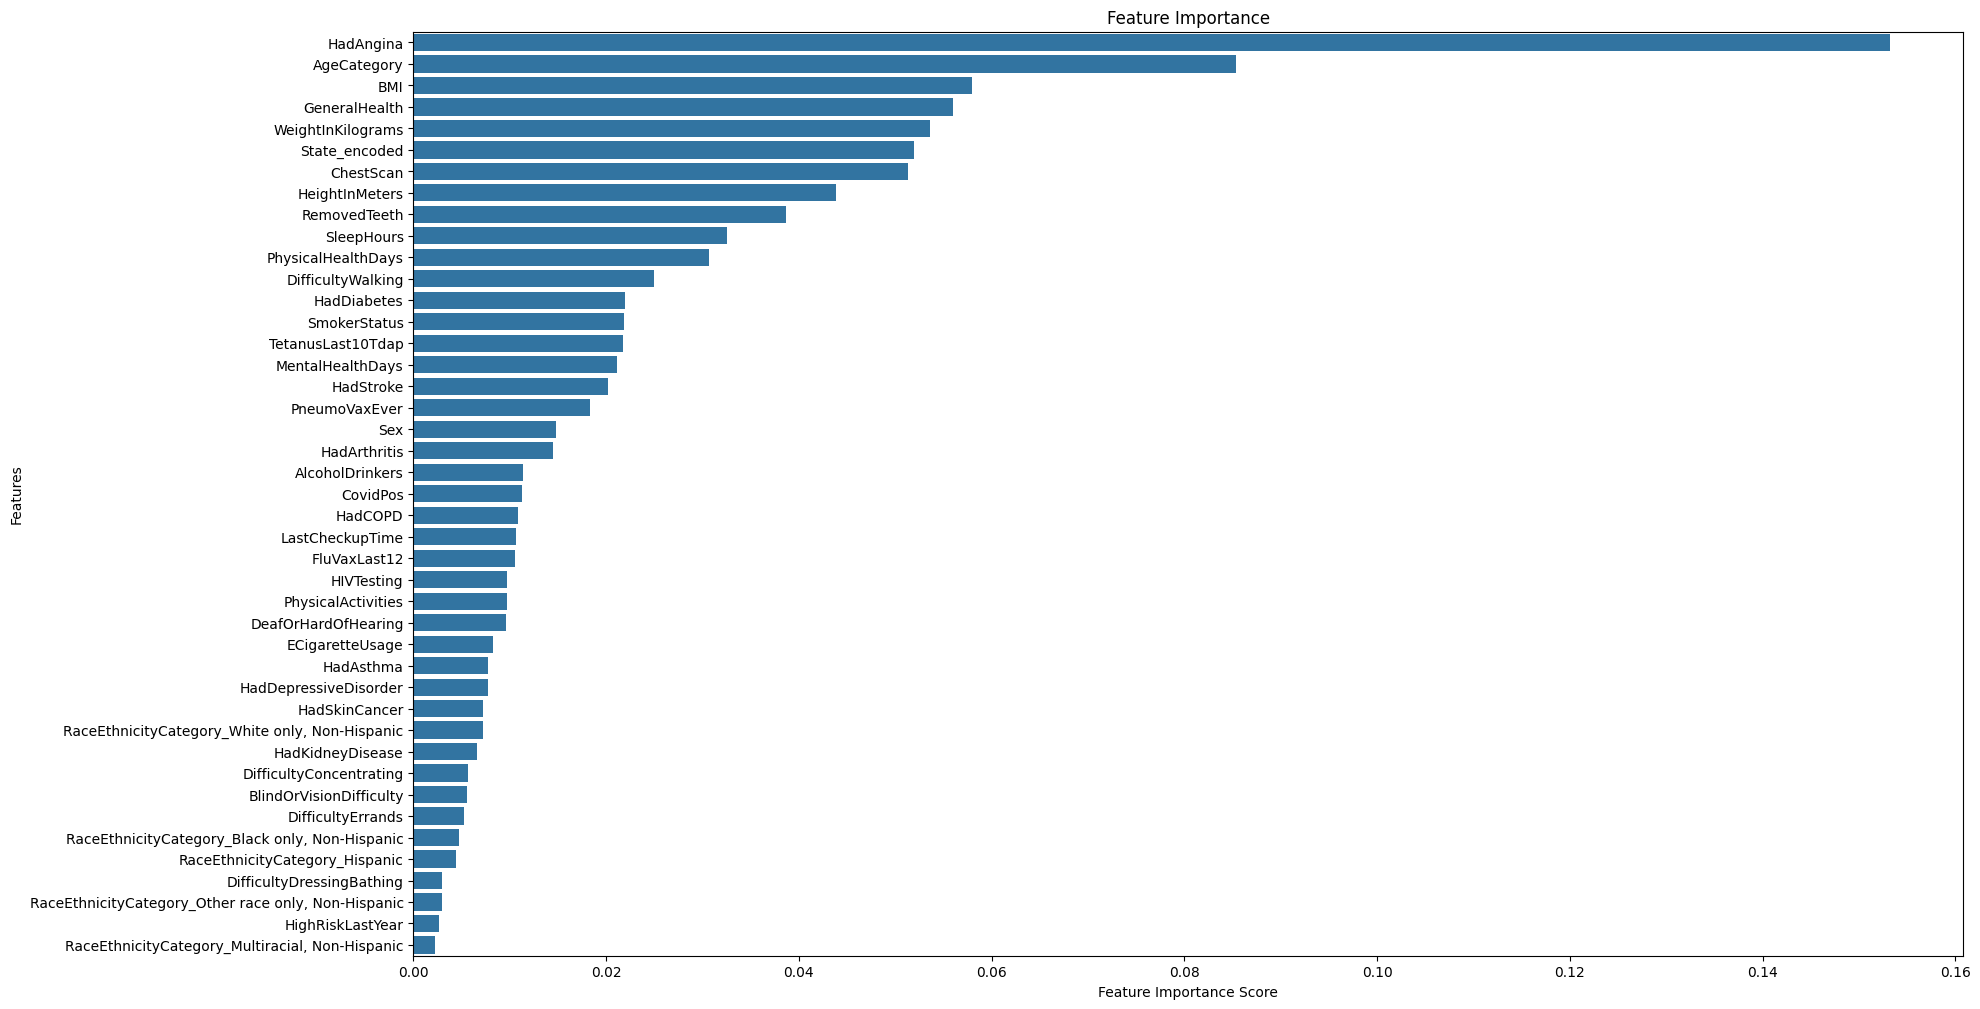

In [7]:
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plotting Feature Importance
plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()